In [4]:
import os
import sys
import torch
from torch import nn
import numpy as np
from torchvision import transforms, models
import matplotlib.pyplot as plt

sys.path.append('..')

from common.utils import load_data_cifar10, get_zh_label
from common.d2l import Timer

### 1. 加载cifar10数据

In [5]:
train_iter, test_iter = load_data_cifar10(32, (244, 244))

Files already downloaded and verified
Files already downloaded and verified


### 2. 加载预训练的VGG模型

In [6]:
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg.classifier[-1] = nn.Linear(4096, 10) # 修改输出层以适应CIFAR-10数据集的类别数量
# 冻结模型的前几层
for param in vgg.features.parameters():
    param.requires_grad = False

### 3. 定义损失函数和优化器

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg.parameters(), lr=0.01, momentum=0.9)

### 4. 微调VGG

In [8]:
timer = Timer()  # 启动一个计时器
num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0  # 预测正确的数量
    total = 0  # 总数量
    for i, (inputs, labels) in enumerate(train_iter):
        optimizer.zero_grad()
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i >= 100:
            break
    train_loss = running_loss / total
    train_acc = correct / total

    print(f'迭代周期 [{epoch + 1}/{num_epochs}], 训练损失: {train_loss:.4f}, 训练精度: {train_acc:.4f}')
    print("用时：", timer.stop())
    break

迭代周期 [1/1], 训练损失: 0.0438, 训练精度: 0.4997
用时： 2534.517992258072


### 5. 保存训练好的参数

In [9]:
import datetime

now_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
torch.save(vgg.state_dict(), f'my_vgg_weights_{now_str}.pth')

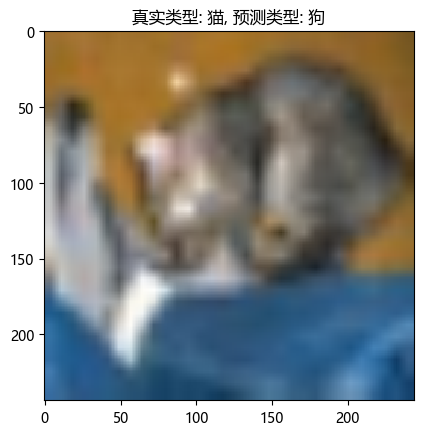

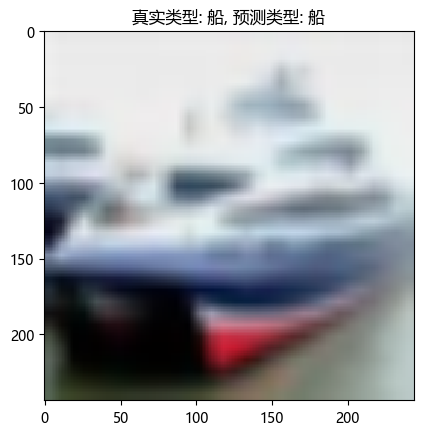

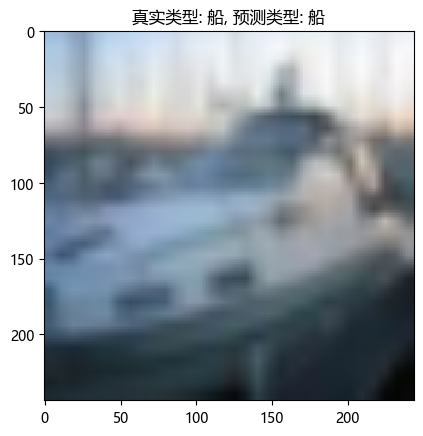

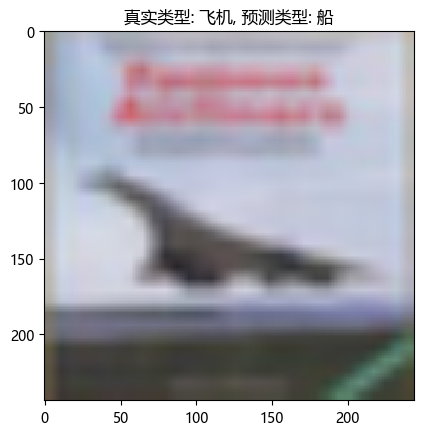

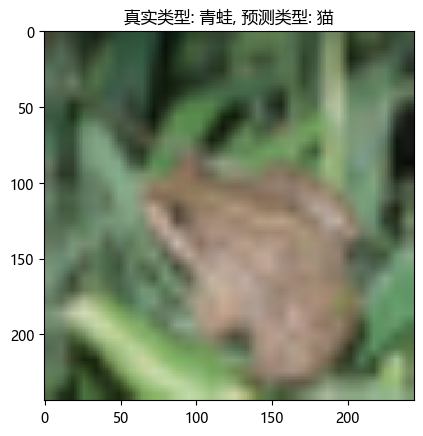

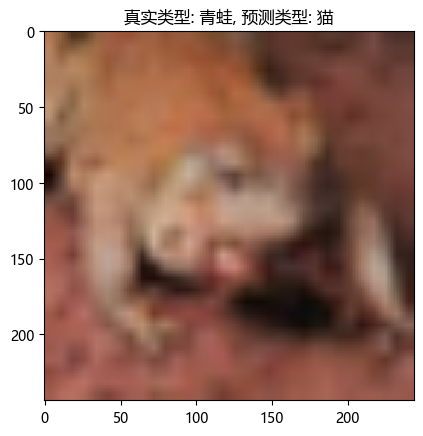

测试集上准确率: 59.375%


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_iter:
        outputs = vgg(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 将张量转换为numpy数组
        images = inputs.cpu().numpy()
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()

        for i in range(len(images)):
            plt.imshow(np.transpose(images[i], (1, 2, 0)), interpolation='nearest')  # 将图像从(C, H, W)转换为(H, W, C)格式
            plt.title(f"真实类型: {get_zh_label(labels[i])}, 预测类型: {get_zh_label(predicted[i])}")
            plt.show()
            if i >= 5:
                break
        break

print(f"测试集上准确率: {100 * correct / total}%")